<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating Static Heatmap Regression Model for Multi-Instance and Multi-Class Landmark Detetection (EndoVis 2015 Challenge)

In this tutorial, we will train and evaluate an direct static heatmap regression model for landmark 
detection with EndoVis 2015 Challenge. We will use part of the EndoVis 2015 challenge dataset to 
construct a multi-instance and multi-class landmark detection task. The dataset contains 4 training 
and 6 testing videos of robotic surgery. The goal is to predict the location of instruments in the video, 
more specifically the tip of the clasper. We only consider the clasper points and ignore the other points,
since they are way more ambiguous. One of the difficulties 

The videos are transformed into images and the annotations are 
given as 2D points. The dataset is split into a training and testing set. The training set contains 4 videos and 
the testing set contains 6 videos, such as specified in the challenge. 

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the UNet model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/static_unet_endovis2015.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [2]:
!python -c "import landmarker" || pip install landmarker

## Setup imports and variables

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, RandStdShiftIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd)
from tqdm import tqdm

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [5]:
fn_keys = ('image', 'seg')
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi/12, np.pi/12),
                        translate_range=(-10, 10),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1)
                        )]

composed_transformd = Compose(spatial_transformd +
                            [RandGaussianNoised(('image', ), prob=0.1, mean=0, std=0.005),  # Add gaussian noise
                        RandStdShiftIntensityd(('image', ), prob=0.1, factors=0.1),  # Add random intensity shift
                        RandScaleIntensityd(('image', ), factors=0.25, prob=0.1),  # Add random intensity scaling
                        RandAdjustContrastd(('image', ), prob=0.1, gamma=(0.5,2)),  # Randomly adjust contrast
                        RandHistogramShiftd(('image', ), prob=0.1),  # Randomly shift histogram
                        ])

In [6]:
# from landmarker.datasets import get_endovis2015_heatmap_datasets

# ds_train, ds_test = get_endovis2015_heatmap_datasets("data", sigma=3, transform = composed_transformd)

In [7]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator
from landmarker.datasets import get_endovis2015_heatmap_datasets

ds_train, ds_test = get_endovis2015_heatmap_datasets("data", transform = composed_transformd,
                                                     grayscale=False,
                                                     dim_img = (512, 512), sigma = 3)

Reading, normalizing and resizing 940 images and landmarks...


  0%|          | 0/940 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 940/940 [00:11<00:00, 82.19it/s]


Creating heatmaps for 940 images... (batch size: 32)


100%|██████████| 29/29 [00:24<00:00,  1.18it/s]


Reading, normalizing and resizing 910 images and landmarks...


100%|██████████| 910/910 [00:11<00:00, 81.61it/s]


Creating heatmaps for 910 images... (batch size: 32)


100%|██████████| 28/28 [00:25<00:00,  1.10it/s]


## Inspecting the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


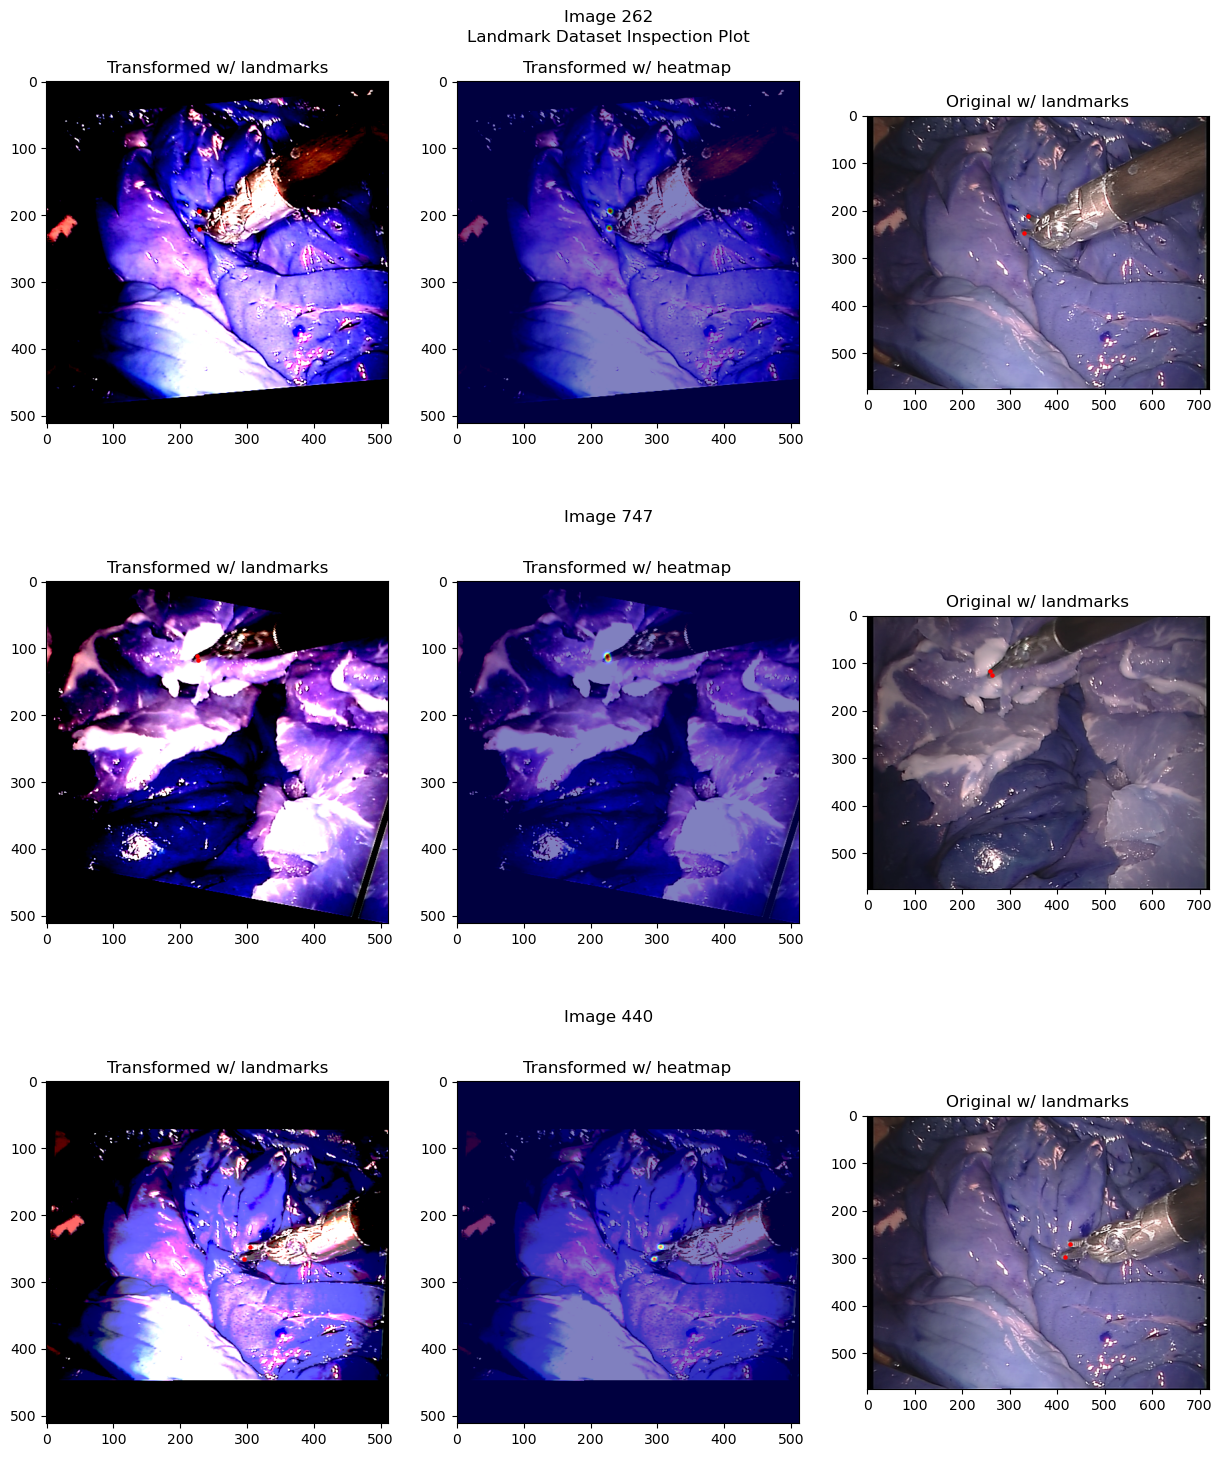

In [8]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
inspection_plot(ds_train, np.random.randint(0, len(ds_train), 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


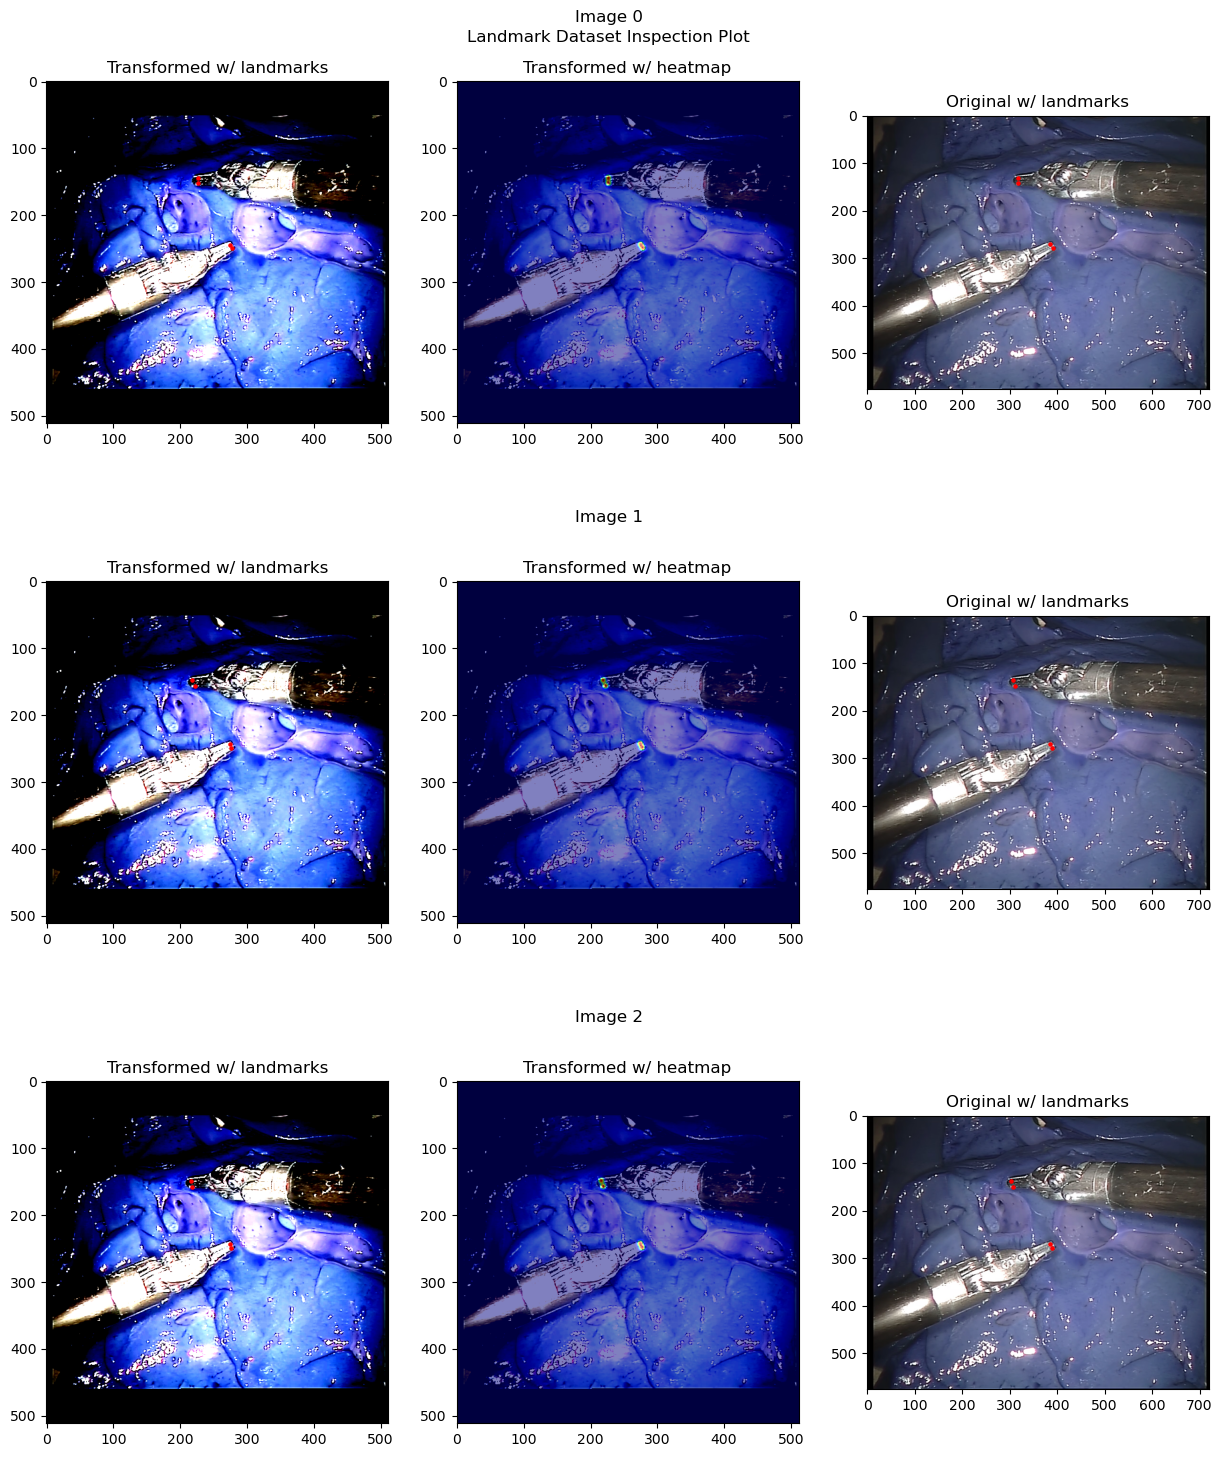

In [9]:
# Plot the first 3 images from the test1 set
inspection_plot(ds_test, range(3))

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [10]:
from torch import nn

from landmarker.models import get_model
from landmarker.train import EarlyStopping, SaveBestModel

model = get_model("UNet", in_channels=3, out_channels=2).to(device)

lr = 1e-4
batch_size = 4
epochs = 1000

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

criterion = nn.BCEWithLogitsLoss()

early_stopping = EarlyStopping(patience=10, verbose=True)
save_best_model = SaveBestModel(verbose=True)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                          patience=20, verbose=True, cooldown=10)

### Setting the data loaders and split training set

In [11]:
split_lengths = [0.8, 0.2]
ds_train_train, ds_train_val = torch.utils.data.random_split(ds_train, split_lengths)
train_loader = DataLoader(ds_train_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(ds_train_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

### Training the model

In [12]:
from landmarker.heatmap.decoder import heatmap_to_coord, heatmap_to_multiple_coord
from landmarker.metrics import point_error

from torch.nn.functional import sigmoid

from landmarker.metrics.metrics import multi_instance_point_error

def train_epoch(model, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, (images, heatmaps, landmarks, _, _, _, _, _, _) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        heatmaps = heatmaps.to(device)
        landmarks = landmarks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, val_loader, criterion, device):
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for _, (images, heatmaps, landmarks, _, _, _ , _, _,
                _) in enumerate(tqdm(val_loader)):
            images = images.to(device)
            heatmaps = heatmaps.to(device)
            landmarks = landmarks.to(device)
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            eval_loss += loss.item()
    return eval_loss / len(val_loader)

def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in range(epochs):
        ds_train.transform = composed_transformd
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        ds_train.transform = None
        val_loss = val_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}")
        early_stopping(val_loss)
        save_best_model(val_loss, model)
        lr_scheduler.step(val_loss)
        if early_stopping.early_stop:
            print(f"Loading best model...")
            model.load_state_dict(torch.load(save_best_model.path))
            break

In [13]:
train(model, train_loader, val_loader, criterion, optimizer, device,
      epochs=epochs)
# model.load_state_dict(torch.load("best_weights_unet_endovis_static.pt"))

<All keys matched successfully>

## Evaluating the model

In [14]:
pred_landmarks = []
true_landmarks = []
dim_origs = []
pixel_spacings = []
paddings = []
tp = []
fp = []
fn = []
test_mpe = 0
test_tp = 0
test_fp = 0
test_fn = 0
model.eval()
with torch.no_grad():
    for i, (images, heatmaps, landmarks, affine_matrixs, _, _ ,
        dim_orig, pixel_spacing, padding) in enumerate(tqdm(test_loader)):
        images = images
        heatmaps = heatmaps
        landmarks = landmarks
        outputs = model(images.to(device)).detach().cpu()
        offset_coords = outputs.shape[1]-landmarks.shape[1]
        pred_landmarks_list, _ = heatmap_to_multiple_coord(sigmoid(outputs), window=5,
                                                           threshold=0.5,
                                                           method="argmax")
        pe_batch, tp_batch, fp_batch, fn_batch, pred_landmarks_torch = multi_instance_point_error(
            true_landmarks=landmarks, pred_landmarks=pred_landmarks_list, dim=(512, 512),
            dim_orig=dim_orig, pixel_spacing=pixel_spacing, padding=padding, reduction="none")
        test_mpe += torch.nanmean(pe_batch).item()
        test_tp += torch.nansum(tp_batch).item()
        test_fp += torch.nansum(fp_batch).item()
        test_fn += torch.nansum(fn_batch).item()
        pred_landmarks.append(pred_landmarks_torch)
        true_landmarks.append(landmarks)
        dim_origs.append(dim_orig)
        pixel_spacings.append(pixel_spacing)
        paddings.append(padding)
        tp.append(tp_batch)
        fp.append(fp_batch)
        fn.append(fn_batch)


test_mpe /= len(test_loader)

print(f"Test Mean PE: {test_mpe:.4f}")
print(f"Test TP: {test_tp:.4f}")
print(f"Test FP: {test_fp:.4f}")
print(f"Test FN: {test_fn:.4f}")

100%|██████████| 228/228 [5:51:17<00:00, 92.45s/it]  

Test Mean PE: 2.8028
Test TP: 8.4474
Test FP: 0.0351
Test FN: 7.5175


In [15]:
from landmarker.metrics import sdr

sdr_test = sdr([4, 5, 10, 20], true_landmarks=torch.cat(true_landmarks, axis=0), pred_landmarks=torch.cat(pred_landmarks, axis=0),
               dim=(512, 512), dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
               padding=torch.cat(paddings, axis=0))
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

SDR for 4mm: 43.3516
SDR for 5mm: 49.1209
SDR for 10mm: 52.4451
SDR for 20mm: 52.4451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


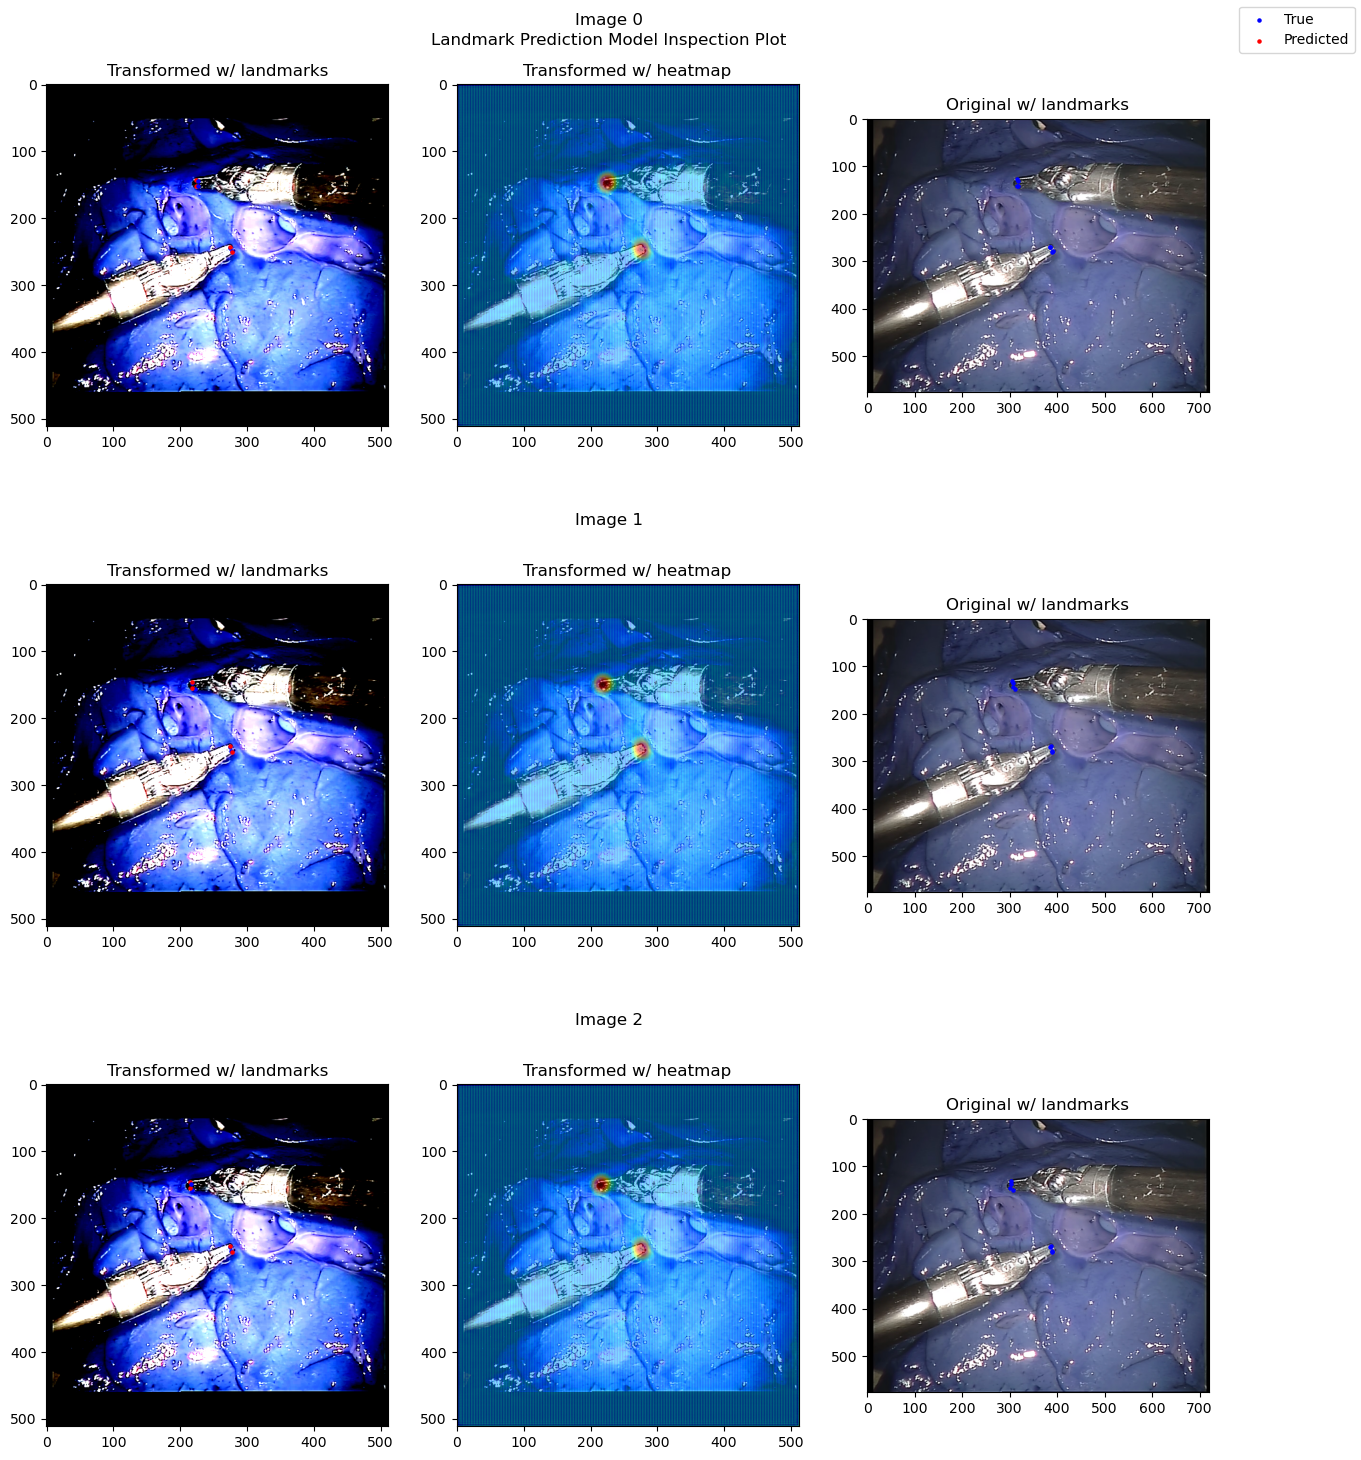

In [16]:
from landmarker.visualize.utils import prediction_inspect_plot_multi_instance
model.to("cpu")
prediction_inspect_plot_multi_instance(ds_test, model, range(3))

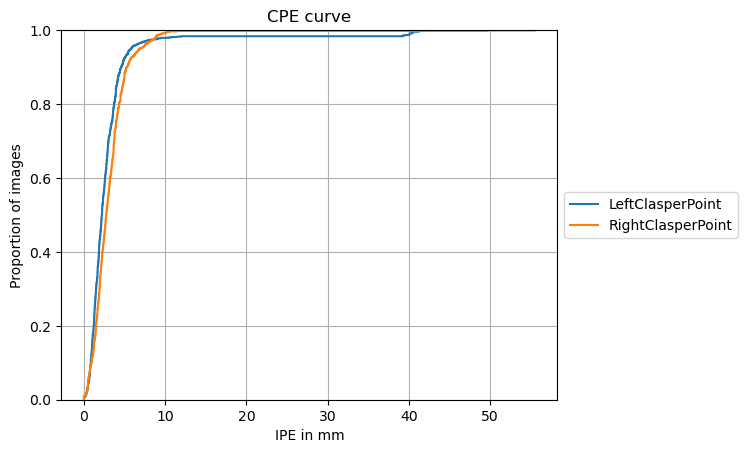

In [17]:
from landmarker.visualize import plot_cpe

plot_cpe(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0), dim=(512, 512),
            dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
            padding=torch.cat(paddings, axis=0), class_names=ds_test.class_names,
            group=False, title="CPE curve", save_path=None,
            stat='proportion', unit='mm', kind='ecdf')

In [18]:
from landmarker.visualize.evaluation import multi_instance_detection_report

multi_instance_detection_report(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0),
                                torch.cat(tp, axis=0), torch.cat(fp, axis=0), torch.cat(fn, axis=0), dim=(512, 512),
                                dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
                                padding=torch.cat(paddings, axis=0), class_names=ds_test.class_names)

Detection report:
1# Instance detection statistics:
Class               TP        FP        FN        TPR       
------------------------------------------------------------
LeftClasperPoint    959.0     6.0       861.0     0.53      
RightClasperPoint   967.0     2.0       853.0     0.53      

2# Point-to-point error (PE) statistics:
Class               Mean      Median    Std       Min       Max       
----------------------------------------------------------------------
LeftClasperPoint    2.95      2.23      4.48      0.13      38.94     
RightClasperPoint   2.97      2.70      2.73      0.20      55.48     

3# Success detection rate (SDR):
Class               SDR (PE≤2mm)   SDR (PE≤2.5mm) SDR (PE≤3mm)   SDR (PE≤4mm)   
--------------------------------------------------------------------------------
LeftClasperPoint    23.13          30.05          36.92          45.16          
RightClasperPoint   17.58          23.90          29.73          41.54          
